# `PMOIRED` example #2: circum stellar disk with inclination, orientation, disk SED, disk geometry etc.

We will analyse VLTI/PIONIER observation of [FS CMa](http://simbad.cds.unistra.fr/simbad/sim-id?Ident=FS+CMa), which have been analysed by model fitting ([Lazareff et al. 2017](https://arxiv.org/pdf/1611.08428.pdf)) as well as image reconstruction ([Kluska et al. 2020](https://arxiv.org/pdf/2004.01594.pdf)). The tutorial shows how to build a model with increasing morphological and chromatic complexity. 

- [Load and show data](#load)
- [Filter data by error bars](#clean)
- [Simple model: gray star + gaussian](#gaussian)
- [Add spectral index](#spectral_index)
- [Add inclination and projection angle](#rotation_projangle)
- [Use a more realistic star+rim+disk geometry](#rim_and_disk)
- [Off centred star to improve closure phase](#off_centred_star)
- [Comparison with models from Lazareff+2017 and Kluska+2020](#comparison)
- [Bonus: assert the detection limit for a planet](#planet)

In [1]:
# -- uncomment to get interactive plots
#%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Image
import pmoired

#from pmoired import tellcorr, dpfit
    
# -- in case you want to limit the number of cores for the multiprocessing functions
# -- will take all CPUs otherwise! 
# pmoired.MAX_THREADS = 8 
print('will use', pmoired.MAX_THREADS, 'CPUs for multiprocessing')

will use 12 CPUs for multiprocessing


# Load files in `PMOIRED` and show data <a id='load'></a>

The `pmoired.OI` constructor is used to create an instance of the OI class stored in the variable `oi`. All basic operations from now on are performed by builtin functions as `oi.function()`. For instance, showing the data is simply done by calling `oi.show()`.  

Data are provided with the tutorial, they were retrieved on https://oidb.jmmc.fr/index.html
- put name of the star: "FS CMa"
- blue tick boxes: only L2 or L3
- data PI= BERGER (upper case!) for the data from the B. Lazareff+ paper
- download and save FITS files

In [2]:
oi = pmoired.OI('./DATA/FS_CMa/*Calibrated.fits')

loadOI: loading ./DATA/FS_CMa/PIONI.2017-10-21T08_37_13.075_oidataCalibrated.fits
  > insname: "PIONIER_Pnat(1.5208180/1.7653541)" targname: "HD45677" pipeline: "pndrs_v3.75"
  > MJD: (1,) [ 58047.35770928599 .. 58047.35770928599 ]
  > A0-B2-D0-J3 | WL: (6,) [ 1.521 .. 1.765 ] um (R~34) {'T3': 4, 'VIS': 6, 'VIS2': 6} | TELL: False 
loadOI: loading ./DATA/FS_CMa/PIONI.2017-10-23T08_05_41.151_oidataCalibrated.fits
  > insname: "PIONIER_Pnat(1.5205512/1.7649570)" targname: "HD45677" pipeline: "pndrs_v3.75"
  > MJD: (1,) [ 58049.33513373472 .. 58049.33513373472 ]
  > A0-B2-C1-D0 | WL: (6,) [ 1.521 .. 1.765 ] um (R~34) {'T3': 4, 'VIS': 6, 'VIS2': 6} | TELL: False 
loadOI: loading ./DATA/FS_CMa/PIONI.2017-10-23T08_40_22.962_oidataCalibrated.fits
  > insname: "PIONIER_Pnat(1.5205512/1.7649570)" targname: "HD45677" pipeline: "pndrs_v3.75"
  > MJD: (1,) [ 58049.359235488504 .. 58049.359235488504 ]
  > A0-B2-C1-D0 | WL: (6,) [ 1.521 .. 1.765 ] um (R~34) {'T3': 4, 'VIS': 6, 'VIS2': 6} | TELL: Fal

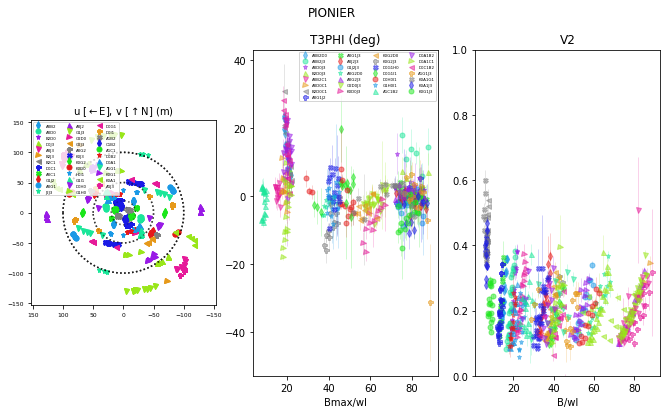

In [3]:
# -- context dictionnary for plotting / fitting:
fit = {'obs':['V2', 'T3PHI']}
oi.setupFit(fit)
oi.show()

<a id='clean'></a>
## clean data to remove points with large uncertainties 
Some data points have large uncertainties. It should not change the interpretation, but they tend to make looking at the data annoying. We can ignore data by adding `max relative error` or `max error` in the setup dictionnary. These refers to dict keyed by observables which set relative or absolute thresholds. Note that one can also force the relative/absolute data errors to have a minimum level with keywords `min error` and `min relative error`. `mult error` allows to multiply errors by a given factor (see `?oi.setupFit`).

One can set the `fit` dictionnary manually for every data file by iterating the list `oi.data`. Each element of `oi.data` is a dictionnary. Interesting elements to decide customise the `fit` dict:
- `'insname'`: the name of the instrument
- `'telescopes'`: list of telescopes
- `'MJD'`: list of MJDs present in the data
- etc.

In [4]:
oi.data[0].keys()

dict_keys(['insname', 'filename', 'targname', 'pipeline', 'LST', 'header', 'OPL', 'WL', 'dWL', 'OI_VIS2', 'OI_VIS', 'OI_T3', 'units', 'telescopes', 'baselines', 'triangles', 'TELLURICS', 'configurations per MJD', 'MJD', 'fit'])

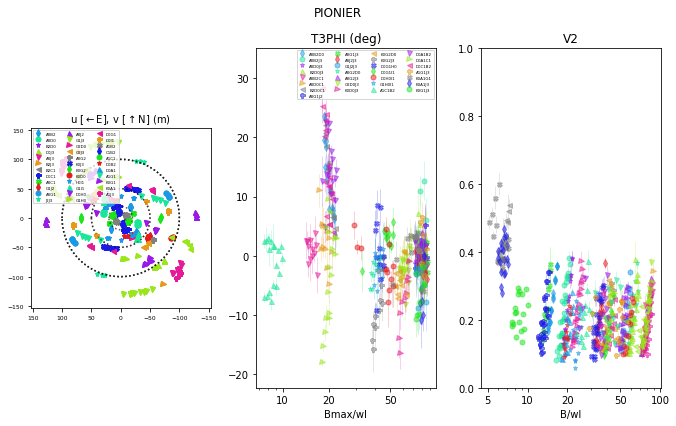

In [5]:
# -- context dictionnary for the fit:
fit = {'obs':['V2', 'T3PHI'], 
       'max relative error':{'V2':.17},
       'max error':{'T3PHI':5.0},
    }

# -- build in function
oi.setupFit(fit)

# -- alternate, by hand:
for d in oi.data:
    # here you can use "if" statement to make custom "fit"
    d['fit'] = fit

oi.show(logB=True)
plt.tight_layout()

# Simplest model: star+gaussian <a id='gaussian'></a>
unresolved star + extended gaussian (centered). Since the model is centro-symetric, no need to fit the phase closure (`T3PHI`). Because we fit more than one parameter, the correlation matrix is also given. in `oi.show()`, we give a field of view to trigger the computation of the synthetic image. Check `?oi.show` to see all options. Here we give the parallax (in mas) via `imPlx=` so a secondary scale is shown in AU. 

[dpfit] 2 FITTED parameters: ['disk,f', 'disk,fwhm']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Wed Mar 27 15:15:43 2024 001/000 CHI2: 1.2099e+02|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 13 function calls ( 11.23 ms on average)
# -- degrees of freedom: 701
# -- reduced chi2: 31.276816916820767
{'disk,f':   1.551, # +/- 0.018
'disk,fwhm':17.85, # +/- 0.46
'star,f':   1.0,
'star,ud':  0.1,
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
              0   1  
 0:   disk,f ### -24 
 1:disk,fwhm -24 ### 


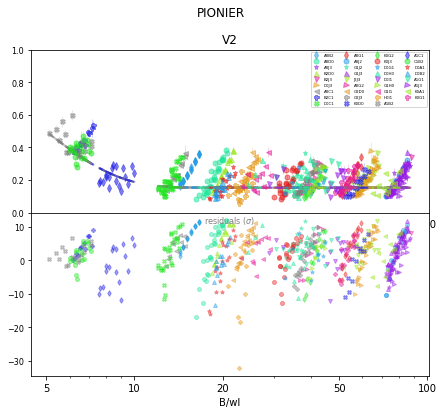

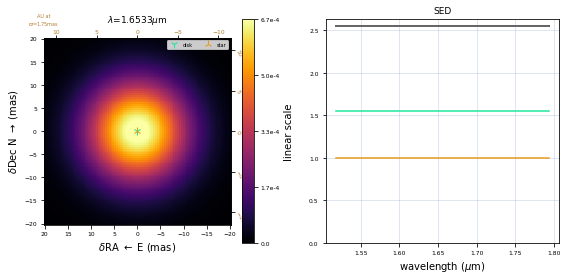

In [6]:
from importlib import reload
reload(pmoired.oifits)
fit = {'obs':['V2'],
       'max relative error':{'V2':.17},
       'min relative error':{'V2':0.05},
      }

param = {'star,ud':0.1, 'star,f':1.0, 
         'disk,fwhm':18., 'disk,f':1.0, 
        }

oi.setupFit(fit)
doNotFit=['star,f', 'star,ud']
oi.doFit(param, doNotFit=doNotFit)
oi.show(imFov=40, imMax='99', logB=True, showUV=False, imPlx=1.75)

## Add slope in the disk spectrum using a spectral index.<a id='spectral_index'></a>

Interferometric observations are sensitive to the ratio of the SED of the components in the field. In our case, the measurements are sensitive to the flux ratio between the star and the disk. We can express the SED of the star as achromatic (the default in `PMOIRED`), but we can also choose to express it in a physical way, for instance as black body radiation (or a good approximation), so the SED we derive for the disk is meaningful. 

Using the keyword `spectrum` for a component, one can define an arbitrary SED for the component, using special string `$WL` for the wavelength in microns. In the [Reyleigh-Jeans regime] (i.e. for wavelengths way past the peak of the Black Body Planck SED), the SED is proportional to $\lambda^{-4}$. More realistically, for FS CMa in the near infrared, the spectral index is of the order of -3.8. For dust sublimation (as we expect to see the dust closest to the star), [Kobayashi et al (2011)](https://ui.adsabs.harvard.edu/abs/2011EP%26S...63.1067K/abstract) provides an estimate of T$_\mathrm{sub}$ of 500 to 2000K depending on the nature of the dust and local conditions. We will use 1300K as typical for silicate-rich dust (Olivine), just to see what spectral index to expect for the rim of the disk (where dust sublimates).

**Tip**: _Expressing the SED as $a\lambda^{b}$ will result in a correlation between $a$ and $b$. To avoid this, is is better to use $a\left(\frac{\lambda}{<\lambda>}\right)^{b}$, where $<\lambda>$ is the average wavelength of the dataset. The value of the spectral index $b$ will remain the same, although the value of $a$ will change between the 2 definitions._

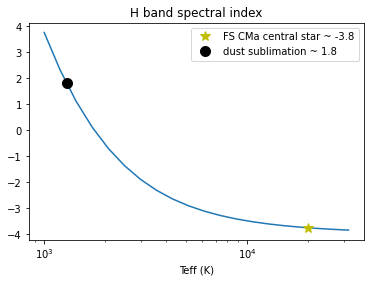

In [7]:
import astropy.units as U
import astropy.constants as C
# -- effective temperature for a B2 type star
T = np.logspace(3, 4.5, 20)
P = []
# -- wavelength range in near infrared H band
l = np.linspace(1.5, 1.8, 10)*U.um

for t in T:    
    # -- Black Body Blambda:
    Bl = 2*C.h*C.c**2/l**5/(np.exp(C.h*C.c/(l*C.k_B*t*U.K))-1)
    # -- compute spectral index 
    P.append(np.polyfit(np.log(l.value/np.mean(l.value)), np.log(Bl.value), 1)[0])
    
plt.close(100)
plt.figure(100)
plt.plot(T, P)
Tstar = 20000 # Be star
plt.plot(Tstar, np.interp(Tstar, T, P), '*y', ms=10, 
        label='FS CMa central star ~ %.1f'%(np.interp(Tstar, T, P)))
Tdust = 1300 # Olivine 
plt.plot(Tdust, np.interp(Tdust, T, P), 'ok', ms=10, 
        label='dust sublimation ~ %.1f'%(np.interp(Tdust, T, P)))

plt.legend()
plt.xlabel('Teff (K)')
plt.title('H band spectral index')

plt.xscale('log')

[dpfit] 3 FITTED parameters: ['disk,A', 'disk,B', 'disk,fwhm']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 17 function calls ( 11.67 ms on average)
# -- degrees of freedom: 664
# -- reduced chi2: 7.198108885578666
{'disk,A':       1.3927, # +/- 0.0080
'disk,B':       2.34, # +/- 0.12
'disk,fwhm':    17.97, # +/- 0.23
'disk,spectrum':'$disk,A*($WL/1.67)**$disk,B',
'star,spectrum':'($WL/1.67)**-3.8',
'star,ud':      0.1,
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
              0   1   2  
 0:   disk,A ###  -9 -23 
 1:   disk,B  -9 ###  -5 
 2:disk,fwhm -23  -5 ### 


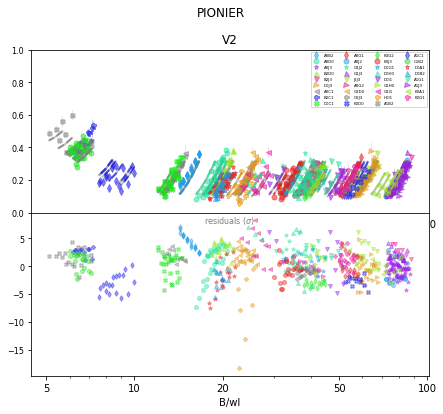

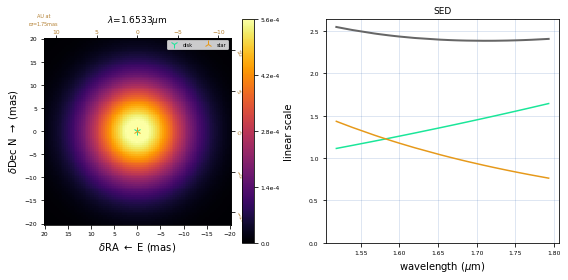

In [8]:
param = {'star,ud':0.1, 
         'star,spectrum':'($WL/1.67)**-3.8', 
         'disk,fwhm':18., 
         'disk,A':1, 
         'disk,B':-2, 
         'disk,spectrum':'$disk,A*($WL/1.67)**$disk,B',
        }
fit = {'obs':['V2'],
       'max relative error':{'V2':.17},
       'min relative error':{'V2':0.05},
      }
oi.setupFit(fit)

doNotFit=['star,ud']
oi.doFit(param, doNotFit=doNotFit)
oi.show(imFov=40, logB=True, imMax='99', imPlx=1.75, showUV=False)

## Inclination and projected angle<a id='inclination_projangle'></a>

Some baselines of similar length show different visibilities: the difference between these baselines is that they have different orientations. The difference in visibilities could be due to oblatness in the disk. To model this, we can add 'incl' and 'projang' to the component, which will squish the component by cos(`incl`) (in degrees) and the long axis will be aligned along projection angle `projang` (in degrees, N=0 and E=90).

Note that compared to the previous model, the reduce $\chi^2$ has improved.

[dpfit] 5 FITTED parameters: ['disk,A', 'disk,B', 'disk,fwhm', 'disk,incl', 'disk,projang']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 31 function calls ( 11.83 ms on average)
# -- degrees of freedom: 662
# -- reduced chi2: 6.367016028248498
{'disk,A':       1.3965, # +/- 0.0076
'disk,B':       2.34, # +/- 0.11
'disk,fwhm':    20.76, # +/- 0.42
'disk,incl':    56.37, # +/- 2.31
'disk,projang': 66.27, # +/- 1.47
'disk,spectrum':'$disk,A*($WL/1.67)**$disk,B',
'star,spectrum':'($WL/1.67)**-3.8',
'star,ud':      0.1,
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
                 0   1   2   3   4  
 0:      disk,A ###  -9 -13   3  -1 
 1:      disk,B  -9 ###  -3   0  -1 
 2:   disk,fwhm -13  -3 ###  79  33 
 3:   disk,incl   3   0  79 ###  29 
 4:disk,projang  -1  -1  33  29 ### 


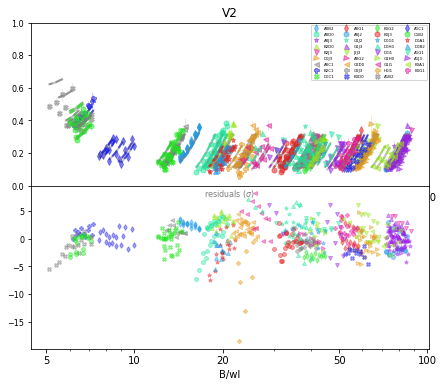

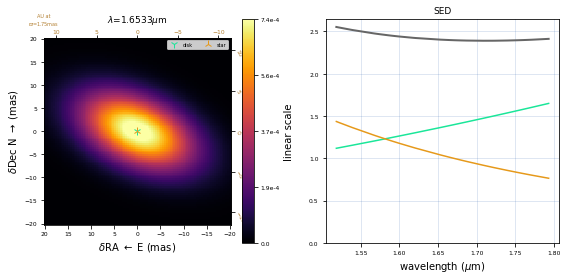

In [9]:
param = {'disk,fwhm':    17.97, # +/- 0.23
    'disk,A':     1.3927, # +/- 0.0080
    'disk,B':      2.44, # +/- 0.12
    'disk,spectrum':'$disk,A*($WL/1.67)**$disk,B',
    'star,spectrum':'($WL/1.67)**-3.8',
    'star,ud':      0.1,
    }
param.update({'disk,incl':60, 'disk,projang':60,})

fit = {'obs':['V2'],
       'max relative error':{'V2':.17},
       'min relative error':{'V2':0.05},
      }
oi.setupFit(fit)

doNotFit=['star,ud']
oi.doFit(param, doNotFit=doNotFit)
oi.show(allInOne=True, imFov=40, logB=True, imMax='99', imPlx=1.75, showUV=False)

# Change the geometry to a more realistic rim <a id='rim_and_disk'></a>

in `PMOIRED`, a disk or a ring can have an arbitrary radial intensity profile, expressed as `profile`, with special character `$R` and `$D` referring to the radius and diameter in mas. A special value for `profile` is `doughnut` which correspond to a smooth parabolic variation going to 0 at the edges of the ring, and peaking at the mid-point:`1-(2*($R-np.mean($R))/np.ptp($R))**2`. The inner and outer diameters of the ring are defined by `diamin` and `diamout`. 

We saw that the data show non-0 closure phase (`T3PHI`), which means the object depart from central symmetry. One expects projection effect to show part of th inner edge being illuminated by the central star, whereas the over side will be shadowed. To simulate this, we can ntroduce an azimuthal intensity variation in the disk, using `az amp1` and `az projang1`, which describe the sinusoidal variation of order 1. `az amp1` should be between 0 and 1, whereas `az projang1` = ±90 corresponds to the smaller axis of the elliptical ring being over and under bright.

**Reminder**: _`profile` does not set the absolute surface brightness so no care is needed to define the `profile` in terms of surface brightness with respect to other components. For this `spectrum` should be used to define the SED (total flux) of the component._

[dpfit] 8 FITTED parameters: ['rim,A', 'rim,B', 'rim,az amp1', 'rim,az projang1', 'rim,diamin', 'rim,diamout', 'rim,incl', 'rim,projang']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Wed Mar 27 15:15:54 2024 029/003 CHI2: 1.1523e+01|
[dpfit] Wed Mar 27 15:16:04 2024 101/012 CHI2: 8.2462e+00|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 154 function calls ( 130.9 ms on average)
# -- degrees of freedom: 1040
# -- reduced chi2: 8.24409170097074
{'rim,A':          1.3407, # +/- 0.0091
'rim,B':          2.06, # +/- 0.13
'rim,az amp1':    0.664, # +/- 0.029
'rim,az projang1':-93.12, # +/- 1.50
'rim,diamin':     0.00, # +/- 0.75
'rim,diamout':    31.42, # +/- 0.35
'rim,incl':       54.21, # +/- 0.83
'rim,projang':    64.14, # +/- 1.08
'rim,profile':    'doughnut',
'rim,spectrum':   '$rim,A*($WL/1.67)**$rim,B',
'star,spectrum':  '($WL/1.67)**-3.8',
'star,ud':        0.1,
}

Correlations (%)  >=90 >=8

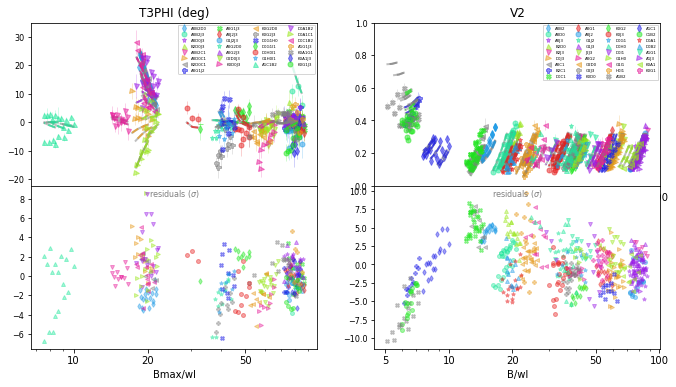

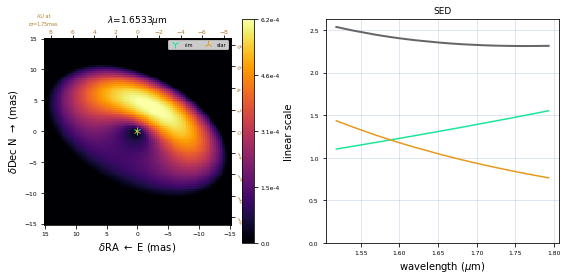

In [10]:
param = {'rim,diamin':     10., # +/- 0.42
         'rim,diamout':     20., # +/- 0.42
         'rim,az amp1':0.5,
         'rim,az projang1':-90,
         'rim,incl':     56.37, # +/- 2.31
         'rim,projang':  66.27, # +/- 1.47
         'rim,A':      1.3965, # +/- 0.0076
         'rim,B':       2.34, # +/- 0.11
         'rim,spectrum': '$rim,A*($WL/1.67)**$rim,B',
         'rim,profile': 'doughnut',
         'star,spectrum':'($WL/1.67)**-3.8',
         'star,ud':      0.1,
        }

fit = {'obs':['V2', 'T3PHI'],
       'max relative error':{'V2':.17},
       'min relative error':{'V2':0.05},
       'max error':{'T3PHI':5.0},
       'min error':{'T3PHI':1.},
      }
oi.setupFit(fit)

if True:
    # -- actually fit parameters
    doNotFit=['star,ud']
    oi.doFit(param, doNotFit=doNotFit)
    param = oi.bestfit['best']
else:
    # -- show parameter without fitting 
    pass

oi.show(param, allInOne=True, imFov=30, imMax='99', logB=True, imPlx=1.75, showUV=False)

## adding an extended disk
We can see that both the visibilities amplitudes and closure phases are not well reproduces at short baselines. It means a large component is needed (larger than the rim). We add an extended disk, beyond the rim, which has its own azimuthal variation (to reproduce the closure phase). Here we arbitrarily give the ring a brightness variation profile in `1/$R**2`, and make it extend up to 4x its inner diameter (which is set to the outer diameter of the rim). The inclination and projection angle are inherited from the rim. To create the new model, the flux can be plit between the inner rim and (the old unique circum stellar component) and the newly added disk. 

The fit takes quite a while to converge (a couple of minutes): the $\chi^2$ decreases very slowly. This is in part due to:
- the difficulty to distinguish the spectral index of the inner rim from the outer disk. This is because we have a relatively small spectral window. A possibility it to use the same for both components as fitting them separatly lead to simiar values and high correlation.
- the inner diameter `rim,diamin` is poorly constrain and goes to 0 (where it is limited internaly). We can fix to to 0 and exclude it from the fit by adding it to the `doNotFit` list.
- the amplitudes of the azimuthal variations saturates to 1. There is a slight internal penalty when the model has negative flux, (`rim,az amp1`>1), which we can re-inforce by adding a prior `prior=[('rim,az amp1', '<', 1)]`. Note that if you have higher order amplitudes, you can have `rim,az amp1`>1 and the flux being positive, so this prior is only valid because we have only `amp1`.

[dpfit] 11 FITTED parameters: ['disk,A', 'disk,B', 'disk,az amp1', 'disk,az projang1', 'rim,A', 'rim,B', 'rim,az amp1', 'rim,az projang1', 'rim,diamout', 'rim,incl', 'rim,projang']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Wed Mar 27 15:16:16 2024 001/000 CHI2: 8.2344e+00|
[dpfit] Wed Mar 27 15:16:27 2024 021/001 CHI2: 6.2941e+00|
[dpfit] Wed Mar 27 15:16:37 2024 042/003 CHI2: 5.3301e+00|
[dpfit] Wed Mar 27 15:16:47 2024 062/005 CHI2: 5.3269e+00|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 79 function calls ( 518.1 ms on average)
# -- degrees of freedom: 1109
# -- reduced chi2: 5.32681616722063
{'disk,A':          0.511, # +/- 0.020
'disk,B':          1.59, # +/- 0.67
'disk,az amp1':    0.99, # +/- 0.29
'disk,az projang1':-101.61, # +/- 8.63
'rim,A':           0.829, # +/- 0.020
'rim,B':           2.30, # +/- 0.42
'rim,az amp1':     1.095, # +/- 0.040
'rim,az projang1': -99.57, # +/- 1.53

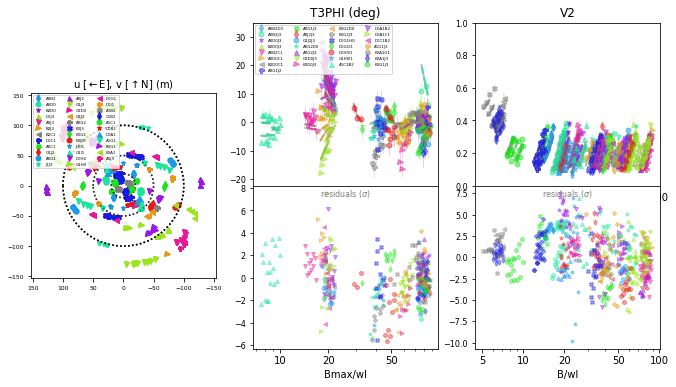

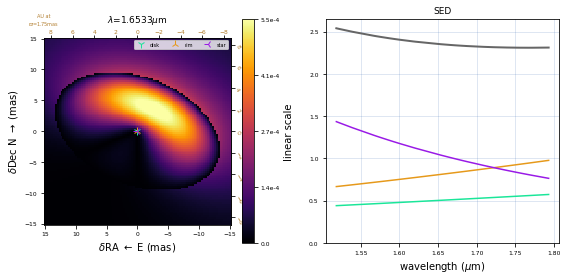

In [11]:
param = {'rim,A':          1.3407, # +/- 0.0091
    'rim,B':          2.06, # +/- 0.13
    'rim,az amp1':    0.664, # +/- 0.029
    'rim,az projang1':-93.12, # +/- 1.50
    'rim,diamin':     0.0, # +/- 0.75
    'rim,diamout':    31.42, # +/- 0.35
    'rim,incl':       54.21, # +/- 0.83
    'rim,projang':    64.14, # +/- 1.08
    'rim,profile':    'doughnut',
    'rim,spectrum':   '$rim,A*($WL/1.67)**$rim,B',
    'star,spectrum':  '($WL/1.67)**-3.8',
    'star,ud':        0.1,
    }

# -- split the flux bewtween the rim and the disk
param['rim,A'] /= 2

# -- add extended disk
param.update({'disk,A':        param['rim,A'], # just set value once, will be fitted later
            'disk,B':          2, 
            'disk,az amp1':    1.0, 
            'disk,az projang1':-90, 
            'disk,diamin':     '$rim,diamout',
            'disk,diamout':    '4*$disk,diamin',
            'disk,incl':       '$rim,incl',
            'disk,profile':    '1/$R**2',
            'disk,projang':    '$rim,projang',
            'disk,spectrum':   '$disk,A*($WL/1.67)**$disk,B',
             })

fit = {'obs':['V2', 'T3PHI'],
       'max relative error':{'V2':.17},
       'min relative error':{'V2':0.05},
       'max error':{'T3PHI':5.0},
       'min error':{'T3PHI':1.},
      }
oi.setupFit(fit)

if True:
    # -- actually fit parameters
    doNotFit=['star,ud', 'rim,diamin']
    oi.doFit(param, doNotFit=doNotFit, prior=[('rim,az amp1', '<', 1), ('disk,az amp1', '<', 1)])
    param = oi.bestfit['best']
else:
    # -- show parameter without fitting 
    pass

oi.show(param, allInOne=True, imFov=30, imMax='99', logB=True, imPlx=1.75)

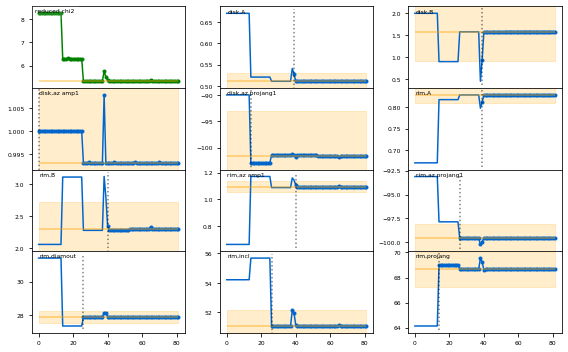

In [12]:
oi.showFit()

## Off-centred star to improve closure phases fit <a id='off_centered_star'></a>

The closure phases are still not perfectly matched. To add degrees of freedom in deviating from central symmetry, we could add orders of azimuthal variations (via `az amp2`, `az projang2` etc.) but the even terms actually do not produce departure from central symmetry. One simple non-central complexity is to allow the star to not be at the centre of the rim+disk: by projection effect, the star can appear off-centered. 

Because we want the star to remain at the centre, to compare our results to similar analysis, we can move the ring and the disk using `x` and `y` (in mas towards E and N respectively). Optical interferometry is not sensitive to the absolute positioning.

`rim,az amp1` and `disk,az amp1` are set to 1 and not fitted.

[dpfit] 11 FITTED parameters: ['disk,A', 'disk,B', 'disk,az projang1', 'rim,A', 'rim,B', 'rim,az projang1', 'rim,diamout', 'rim,incl', 'rim,projang', 'rim,x', 'rim,y']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Wed Mar 27 15:17:05 2024 001/000 CHI2: 5.5747e+00|rim,x=-5.00e-01|rim,y=5.00e-01
[dpfit] Wed Mar 27 15:17:15 2024 020/001 CHI2: 4.9024e+00|rim,x=7.11e-01|rim,y=5.79e-01
[dpfit] Wed Mar 27 15:17:26 2024 039/003 CHI2: 4.7855e+00|rim,x=1.19e+00|rim,y=9.00e-01
[dpfit] Wed Mar 27 15:17:36 2024 058/005 CHI2: 4.7706e+00|rim,x=1.30e+00|rim,y=9.98e-01
[dpfit] Wed Mar 27 15:17:47 2024 077/007 CHI2: 4.7622e+00|rim,x=1.44e+00|rim,y=1.09e+00
[dpfit] Wed Mar 27 15:17:57 2024 096/008 CHI2: 4.7612e+00|rim,x=1.48e+00|rim,y=1.12e+00
[dpfit] Wed Mar 27 15:18:08 2024 115/010 CHI2: 4.7606e+00|rim,x=1.51e+00|rim,y=1.15e+00
[dpfit] Wed Mar 27 15:18:18 2024 133/012 CHI2: 4.7606e+00|rim,x=1.52e+00|rim,y=1.16e+00
[dpfit] Both actual and predicted relative reductions in

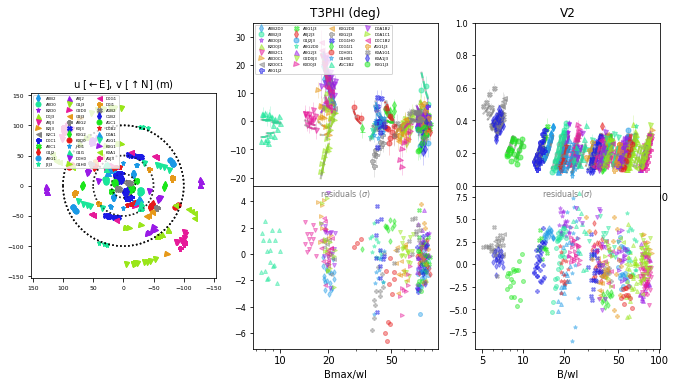

In [13]:
param = {'disk,A':          0.511, # +/- 0.020
        'disk,B':          1.59, # +/- 0.67
        'disk,az amp1':    0.99, # +/- 0.29
        'disk,az projang1':-101.61, # +/- 8.63
        'rim,A':           0.829, # +/- 0.020
        'rim,B':           2.30, # +/- 0.42
        'rim,az amp1':     1.095, # +/- 0.040
        'rim,az projang1': -99.57, # +/- 1.53
        'rim,diamout':     27.85, # +/- 0.36
        'rim,incl':        51.08, # +/- 1.07
        'rim,projang':     68.65, # +/- 1.38
        'disk,diamin':     '$rim,diamout',
        'disk,diamout':    '4*$disk,diamin',
        'disk,incl':       '$rim,incl',
        'disk,profile':    '1/$R**2',
        'disk,projang':    '$rim,projang',
        'disk,spectrum':   '$disk,A*($WL/1.67)**$disk,B',
        'rim,diamin':      0.0,
        'rim,profile':     'doughnut',
        'rim,spectrum':    '$rim,A*($WL/1.67)**$rim,B',
        'star,spectrum':   '($WL/1.67)**-3.8',
        'star,ud':         0.1,
        }

param.update({'rim,x':-0.5, 'rim,y':0.5, 
              'disk,x':'$rim,x', 'disk,y':'$rim,y', 
             })

fit = {'obs':['V2', 'T3PHI'],
       'max relative error':{'V2':.17},
       'min relative error':{'V2':0.05},
       'max error':{'T3PHI':5.0},
       'min error':{'T3PHI':1.},
      }
oi.setupFit(fit)

if True:
    # -- actually fit parameters
    doNotFit=['star,ud', 'rim,diamin']
    # -- set amp1 to 1 and do not fit it
    param['rim,az amp1']=1; doNotFit.append('rim,az amp1')
    param['disk,az amp1']=1; doNotFit.append('disk,az amp1')
    oi.doFit(param, doNotFit=doNotFit, follow=['rim,x', 'rim,y'])
    param = oi.bestfit['best']
else:
    # -- show parameter without fitting 
    pass

oi.show(param, allInOne=True, imFov=30, imMax='99', logB=True, imPlx=1.75)

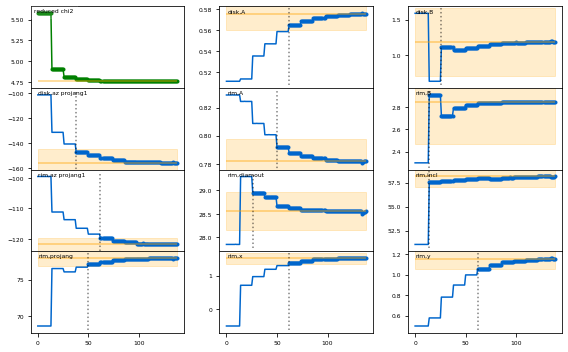

In [14]:
oi.showFit()

# Comparison with other analysis<a id='comparison'></a>

What we have done with `PMOIRED` is building a complex model by starting from a simple model and making it more complex, informed both by what we expect of the object and what the data tell us:
- the overall variations of visibilities and what we expect the object to be led us to model an unresolved star + environment
- the chromatic variations of visibilities indicated that the SEDs of the star and environment have different spetral indices
- the environment is elongated, which we interpret as a inclination effect. 
- We switched from a gaussian environment to a ring to simulate the inner rim of a disk (with an inner cavity)
- the environment departs from the central symmetry, so we introduced azimuthal variations (but left the inclined ring centered on the star) 
- we introduced a large structure (extended disk, beyond the rim) to model the visibilities and closure phases at smallest baselines.

We can compare our model to analysis of the same or similar data:

- [Lazareff et al. 2017](https://arxiv.org/pdf/1611.08428.pdf), image shown on [figure D1 (lower left, FS CMa==HD45677)](https://www.aanda.org/articles/aa/full_html/2017/03/aa29305-16/aa29305-16-fig26.jpg). The model is composed of 3 components: 1) a unresolved central star 2) an infinitely thin ring with sinusoidal azimuthal variations, convolved by a gaussian the size of the resolution of the interferometer 3) a fully resolved component, which shifts the visibility by a certain factor 

- [Kluska et al. 2020](https://arxiv.org/pdf/2004.01594.pdf), image shown on [figure 2 (upper left, FS CMa==HD45677)](https://www.aanda.org/articles/aa/full_html/2020/04/aa33774-18/aa33774-18-fig2.jpg): this image is obtained by image reconstruction.

The 3 interpretations find an elongated structure much brighter on the same side, at the same distance from the central star. When interpreted as an effect of projection, the derived inclination of the the 3 interpretations agrees within 10º or so. 

Despite the complexity of our model, the agreement with the data is not perfect: in particular, the closure phases at long baselines (e.g. triangle K0D0J3) still show residuals because of small details we have not included in our model and we can see in the reconstructed image.

Note that the synthetic image cubes is stored in `oi.images`, a dictionnary containing the cube, as well as the X and Y coordinates of the pixel. 

/tmp/ipykernel_9318/959922873.py:83: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


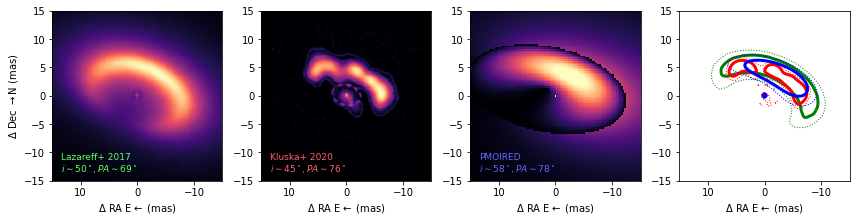

In [15]:
import matplotlib.image as mpimg 
from scipy import fftpack
import os

# == load and show screen capture from Lazareff+ 2017
Laz = mpimg.imread(os.path.join('DATA', 'FS_CMa', 'FSCMa_Lazareff_20x20mas.png'))[::2,::2,0]
xLaz, yLaz = np.linspace(20, -20, Laz.shape[1]), np.linspace(20, -20, Laz.shape[0])
XLaz, YLaz = np.meshgrid(xLaz, yLaz)
# -- convolve image to remove central cross
K = np.exp(-(XLaz**2+YLaz**2)/.1)
K /= np.sum(K)
Laz = fftpack.ifft2(fftpack.fft2(Laz)*fftpack.fft2(K)).real
Laz = np.roll(Laz, Laz.shape[0]//2, axis=0)
Laz = np.roll(Laz, Laz.shape[1]//2, axis=1)

# == load and show screen capture from Kluska+ 2020
Klu = mpimg.imread(os.path.join('DATA', 'FS_CMa', 'FSCMa_Kluska_13x13mas.png'))[::2,::2,0]
Klu = np.max(Klu)-Klu # reverse image
Klu[-50:,:] = np.median(Klu) # -- remove tag
# Klu -= np.median(Klu) #  -- remove background
# Klu *= Klu>0
xKlu, yKlu = np.linspace(13, -13, Klu.shape[1]), np.linspace(13, -13, Klu.shape[0])
XKlu, YKlu = np.meshgrid(xKlu, yKlu)
# -- convolve image to remove contour lines
K = np.exp(-(XKlu**2+YKlu**2)/.05)
K /= np.sum(K)
Klu = fftpack.ifft2(fftpack.fft2(Klu)*fftpack.fft2(K)).real
Klu = np.roll(Klu, Klu.shape[0]//2, axis=0)
Klu = np.roll(Klu, Klu.shape[1]//2, axis=1)

# == show images in the same frame
plt.close(100);
fig = plt.figure(100, figsize=(12, 3.5), constrained_layout=True) 
ax1=plt.subplot(141, aspect='equal')
#gs = fig.add_gridspec(4, 3)
#ax1 = fig.add_subplot(gs[0, 0], aspect='equal')

plt.pcolormesh(XLaz, YLaz, Laz, shading='auto', cmap='magma')
plt.title('Lazareff+ 2017\n'+r'$i\sim50^\circ, PA\sim69^\circ$', 
          fontsize=9, x=0.05, y=0.0, ha='left', va='bottom', color=(0.4, 1, 0.4))
plt.ylabel(r'$\Delta$ Dec $\rightarrow$N (mas)')
plt.xlabel(r'$\Delta$ RA E$\leftarrow$ (mas)')

ax2=plt.subplot(142, aspect='equal', sharex=ax1, sharey=ax1)
ax2.set_facecolor('k')
#ax2 = fig.add_subplot(gs[1, 0], aspect='equal', sharex=ax1, sharey=ax1)

plt.pcolormesh(XKlu, YKlu, Klu, shading='auto', cmap='magma')

plt.title('Kluska+ 2020\n'+r'$i\sim45^\circ, PA\sim76^\circ$', 
          fontsize=9, x=0.05, y=0.0, ha='left', va='bottom', color=(1, 0.4, 0.4))
#plt.ylabel(r'$\Delta$ Dec $\rightarrow$N (mas)')
plt.xlabel(r'$\Delta$ RA E$\leftarrow$ (mas)')

ax3=plt.subplot(143, aspect='equal', sharex=ax1, sharey=ax1)
#ax3 = fig.add_subplot(gs[2,0], aspect='equal', sharex=ax1, sharey=ax1)

plt.pcolormesh(oi.images['X'], oi.images['Y'], 
               np.mean(oi.images['cube'], axis=0), 
               shading='auto', cmap='magma', vmax=np.percentile(np.mean(oi.images['cube'], axis=0), 99))
plt.title('PMOIRED\n'+r'$i\sim%.0f^\circ, PA\sim%.0f^\circ$'%(oi.bestfit['best']['rim,incl'],
                                                          oi.bestfit['best']['rim,projang']), 
          fontsize=9, x=0.05, y=0.0, ha='left', va='bottom', color=(0.4, 0.4, 1))
#plt.ylabel(r'$\Delta$ Dec $\rightarrow$N (mas)')
plt.xlabel(r'$\Delta$ RA E$\leftarrow$ (mas)')
plt.xlim(-15, 15); plt.ylim(-15, 15)
ax3.invert_xaxis()

ax4=plt.subplot(144, aspect='equal', sharex=ax1, sharey=ax1)
#plt.title('95% percentiles')
plt.contour(XLaz, YLaz, Laz, [np.percentile(Laz, 92), np.percentile(Laz, 96)], 
            colors='g', linewidths=[1, 3], linestyles=['dotted', 'solid'])
plt.contour(XKlu, YKlu, Klu, [np.percentile(Klu, 92), np.percentile(Klu, 96)], 
            colors='r', linewidths=[1, 3],  linestyles=['dotted', 'solid'])
plt.contour(oi.images['X'], oi.images['Y'], np.mean(oi.images['cube'], axis=0), 
                [np.percentile(np.mean(oi.images['cube'], axis=0), 92),
                 np.percentile(np.mean(oi.images['cube'], axis=0), 96)], 
            colors='b', linewidths=[1, 3], linestyles=['dotted', 'solid'])
plt.xlabel(r'$\Delta$ RA E$\leftarrow$ (mas)')
#plt.ylabel(r'$\Delta$ Dec $\rightarrow$N (mas)')
plt.xlim(-15, 15); plt.ylim(-15, 15)
ax4.invert_xaxis()
plt.tight_layout()

# Bonus: assert the detection limit for a companion (planet?)<a id='planet'></a>

Same as in the [AX Cir analysis in PMOIRED examples](https://github.com/amerand/PMOIRED/blob/master/examples/companion%20search%20AXCir.ipynb), based on the feature in [CANDID](https://github.com/amerand/CANDID).

Assuming that the best model is the one we found before, we add a third unresolved component. Using `detectionLimit` in a way very similar to `gridSearch`. We define an exploration pattern randomising on the position of the third components, and estimating the flux leading to a 3$\sigma$ detection. This method was described in [Absil et al (2011)](https://ui.adsabs.harvard.edu/abs/2011A%26A...535A..68A/abstract). Using `showLimGrid`, we see the detection level as function of position of third component (left), as well as the histogram of the its 3$\sigma$ magnitude. Note that we need to set `mag=True` option to get the display in magnitude, rather than straight fluxes. Note also that interpretating the result needs to take into account the flux of the primary, which is 1 in our case.  

_Warning_: this can take several minutes to compute, depending how fast your computer is and how many CPUs are available

Wed Mar 27 15:18:28 2024: running 50 fits on 12 processes
Wed Mar 27 15:19:33 2024: [████████████████████████████████████████████████████████████]50/50   0s   left
Wed Mar 27 15:19:33 2024: it took 64.8s, 1.30s per fit on average [46.3 fit/minute]
distribution of 3.0sigma detections:
 median planet,flux : 4.0754  (mag)
 1sigma (68%) 3.7832 -> 4.2954
        (90%) 3.6886 -> 4.3244


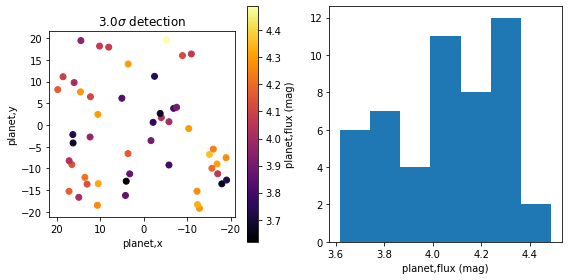

In [16]:
# -- best model from above
best = oi.bestfit['best']

# -- add planet
best.update({'planet,ud':0, 'planet,x':0, 'planet,y':0, 'planet,spectrum':'$planet,flux*($WL/1.67)**-3.8', 'planet,flux':0.01})

# -- random exploration
expl = {'rand':{'planet,x':(-20,20), 'planet,y':(-20, 20)}}

# -- just in case it was not done before...
fit = {'obs':['V2', 'T3PHI'],
       'max relative error':{'V2':.17},
       'min relative error':{'V2':0.05},
       'max error':{'T3PHI':5.0},
       'min error':{'T3PHI':1.},
      }
oi.setupFit(fit)

oi.detectionLimit(expl, 'planet,flux', model=best, Nfits=50, nsigma=3)
 
oi.showLimGrid(mag=True)